# Time Series Analysis - Forecasting Crypto Values

In [ ]:
import os
from IPython.display import Image
# Image("streamlit.png",width=900, height=700)

## 0. Agenda:

1. Loading the data
2. Function for ARIMA Tuning
3. Runing Arima and Ploting Results
4. Runing the best model
5. Runing it all togehter
6. Streamlit App


In [19]:
# pip install yfinance

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from itertools import product
import warnings

# Ignore warnings


[*********************100%***********************]  1 of 1 completed


In [35]:
warnings.filterwarnings("ignore")

# Step 1: Pull BTC data for the last 3 months
btc_data = yf.download('BTC-USD', period='1y', interval='1d')
btc_data = btc_data[['Close']].dropna()

[*********************100%***********************]  1 of 1 completed


In [36]:
# Prepare train-test split (80% train, 20% test)
train_size = int(len(btc_data) * 0.8)
train, test = btc_data[:train_size], btc_data[train_size:]

### 5. Runing it all togehter

ARIMA(0, 0, 0) - AIC:7772.711693997377
ARIMA(0, 0, 1) - AIC:6060.877592563189
ARIMA(0, 0, 2) - AIC:5909.834231435616
ARIMA(0, 0, 3) - AIC:5717.6249478608825
ARIMA(0, 0, 4) - AIC:5674.285384775703
ARIMA(0, 0, 5) - AIC:5732.033660709072
ARIMA(0, 1, 0) - AIC:5214.297332225025
ARIMA(0, 1, 1) - AIC:5216.043084488761
ARIMA(0, 1, 2) - AIC:5218.039553165967
ARIMA(0, 1, 3) - AIC:5218.037577128386
ARIMA(0, 1, 4) - AIC:5218.304700281292
ARIMA(0, 1, 5) - AIC:5220.212897599762
ARIMA(0, 2, 0) - AIC:5400.739455107833
ARIMA(0, 2, 1) - AIC:5362.627741916136
ARIMA(0, 2, 2) - AIC:5344.737215106931
ARIMA(0, 2, 3) - AIC:5315.564847220039
ARIMA(0, 2, 4) - AIC:5317.52306166734
ARIMA(0, 2, 5) - AIC:5333.740854826213
ARIMA(1, 0, 0) - AIC:5239.286540814857
ARIMA(1, 0, 1) - AIC:5241.296318056275
ARIMA(1, 0, 2) - AIC:5242.836962507363
ARIMA(1, 0, 3) - AIC:5238.745473310581
ARIMA(1, 0, 4) - AIC:5238.801670099972
ARIMA(1, 0, 5) - AIC:5240.800497733317
ARIMA(1, 1, 0) - AIC:5216.032028671521
ARIMA(1, 1, 1) - AIC:5218

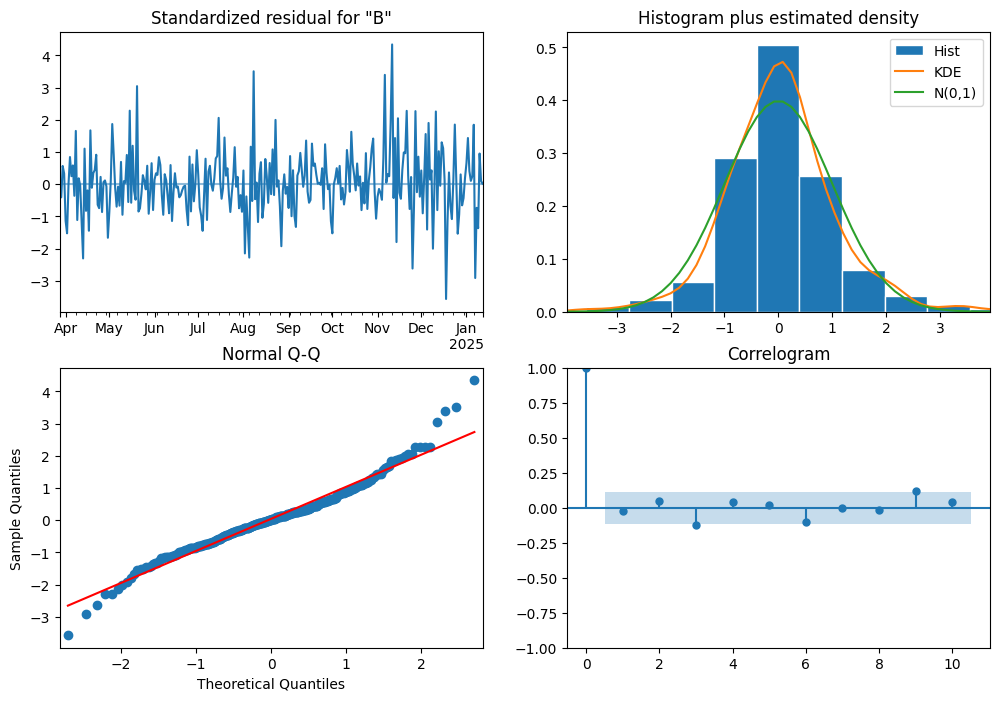

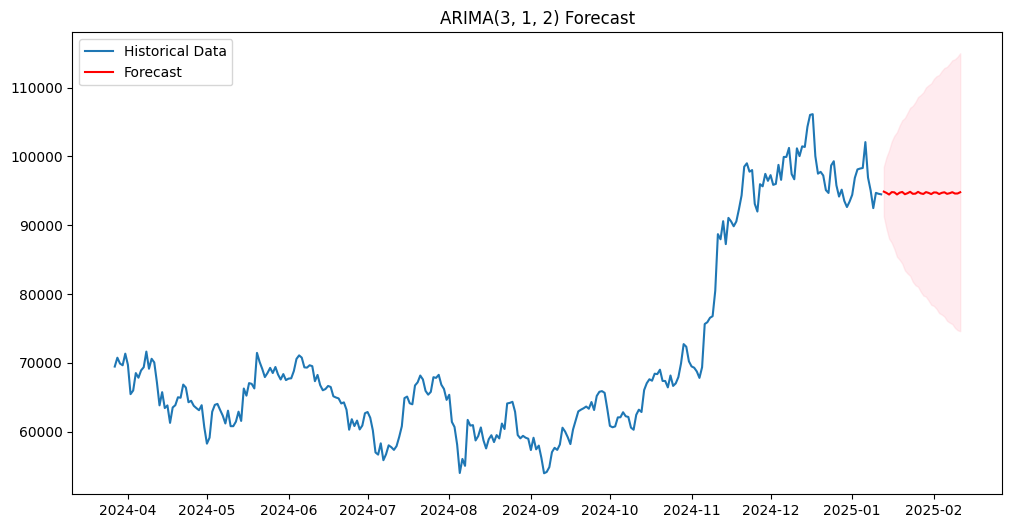

In [37]:
# Grid Search for ARIMA Parameters
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# Define parameter range (adjusted for cryptocurrency volatility)
p_values = range(0, 6)  # AR term
d_values = range(0, 3)  # Differencing
q_values = range(0, 6)  # MA term

# Create a list of all parameter combinations
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

# Initialize best parameters and AIC value
best_aic = float('inf')
best_params = None
best_model = None

# Use your existing dataframe - assuming it's called 'df' and has a datetime index
# and the target column is named 'Close'
# You should modify this part as needed
train_data = train['Close']  # Adjust column name if needed

# Grid search
results = []
for pdq in pdq_combinations:
    try:
        model = ARIMA(train_data, order=pdq)
        model_fit = model.fit()
        aic = model_fit.aic
        results.append([pdq, aic])
        
        # Update best parameters if this model has lower AIC
        if aic < best_aic:
            best_aic = aic
            best_params = pdq
            best_model = model_fit
            
        print(f'ARIMA{pdq} - AIC:{aic}')
    except:
        continue

# Create DataFrame with results
results_df = pd.DataFrame(results, columns=['pdq', 'aic'])
results_df = results_df.sort_values(by='aic', ascending=True)
print(f"\nBest ARIMA model: ARIMA{best_params} with AIC: {best_aic}")

# Plot diagnostics for best model
best_model.plot_diagnostics(figsize=(12, 8))

# Make forecasts with the best model
# Assuming forecast_steps is the number of steps you want to forecast
forecast_steps = 30  # Adjust as needed
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot the forecasts
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Historical Data')
plt.plot(forecast.predicted_mean, color='r', label='Forecast')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title(f'ARIMA{best_params} Forecast')
plt.legend()
plt.show()

Testing best model ARIMA(3, 1, 2)...


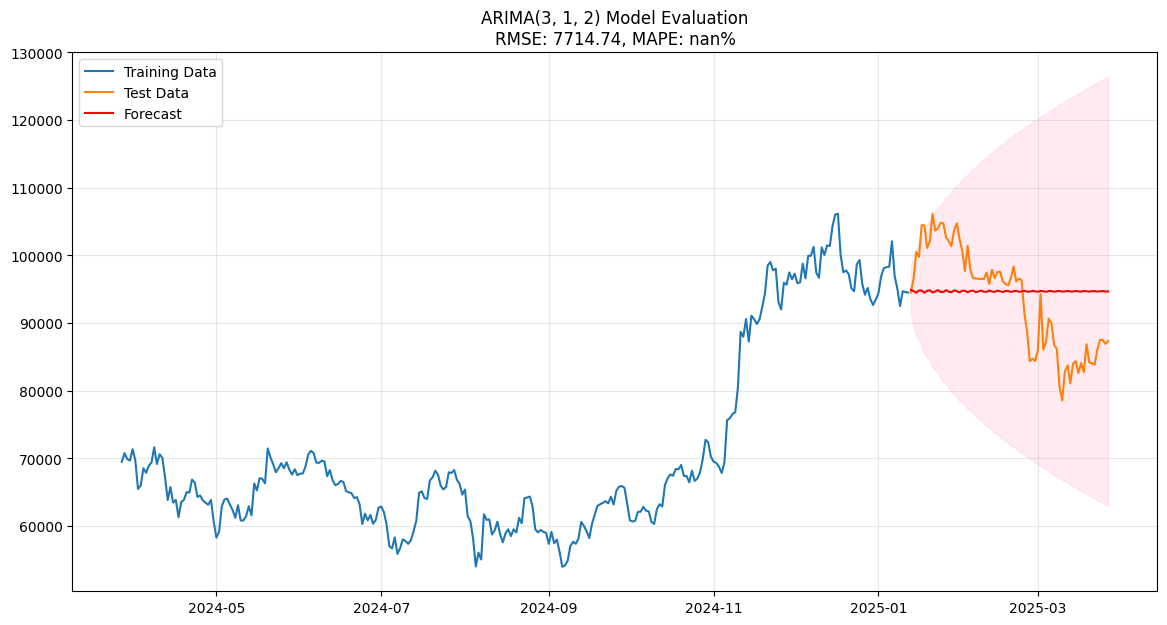

RMSE: 7714.7357
MAPE: nan%


In [38]:
def evaluate_arima_model(data, order, train_size=0.8, plot=True):
    """
    Evaluate an ARIMA model with train-test split and visualize results.
    
    Parameters:
    -----------
    data : pandas.Series
        Time series data for modeling (typically closing prices)
    order : tuple
        ARIMA order (p,d,q)
    train_size : float
        Proportion of data to use for training (default: 0.8)
    plot : bool
        Whether to generate visualization plot
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics and fitted model
    """
    # Create train-test split
    train_size = int(len(data) * train_size)
    train, test = data[:train_size], data[train_size:]
    
    # Fit the model on training data
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    
    # Forecast for the test period
    forecast = model_fit.forecast(steps=len(test))
    
    # Ensure forecast has the same index as test for comparison
    forecast = pd.Series(forecast, index=test.index)
    
    # Calculate metrics
    rmse = sqrt(mean_squared_error(test, forecast))
    
    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-10
    mape = np.mean(np.abs((test - forecast) / (test + epsilon))) * 100
    
    # Visualize results
    if plot:
        plt.figure(figsize=(14, 7))
        plt.plot(train, label='Training Data')
        plt.plot(test, label='Test Data')
        plt.plot(forecast, label='Forecast', color='red')
        
        # Add confidence intervals
        pred_conf = model_fit.get_forecast(steps=len(test)).conf_int()
        plt.fill_between(test.index, 
                         pred_conf.iloc[:, 0], 
                         pred_conf.iloc[:, 1], 
                         color='pink', alpha=0.3)
        
        plt.title(f'ARIMA{order} Model Evaluation\nRMSE: {rmse:.2f}, MAPE: {mape:.2f}%')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return {
        'model': model_fit,
        'train': train,
        'test': test,
        'forecast': forecast,
        'rmse': rmse,
        'mape': mape
    }

# Example usage with best parameters from grid search
print(f"Testing best model ARIMA{best_params}...")
best_model_evaluation = evaluate_arima_model(btc_data['Close'], best_params)
print(f"RMSE: {best_model_evaluation['rmse']:.4f}")
print(f"MAPE: {best_model_evaluation['mape']:.4f}%")

### 6. Streamlit App

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from itertools import product
import warnings
import streamlit as st
from PIL import Image

# Ignore warnings
warnings.filterwarnings("ignore")

# Streamlit configuration
st.set_page_config(layout="wide")
st.markdown("<style>.main {padding-top: 0px;}</style>", unsafe_allow_html=True)

# Add images
st.sidebar.image("Pic1.png", use_column_width=True)
st.image("Pic2.png", use_column_width=True)

# Add main title
st.markdown("<h1 style='text-align: center; margin-top: -20px;'>ARIMA Forecasting Model</h1>", unsafe_allow_html=True)

# Sidebar inputs
st.sidebar.header("Model Parameters")
crypto_symbol = st.sidebar.text_input("Cryptocurrency Symbol", "BTC-USD")
prediction_ahead = st.sidebar.number_input("Prediction Days Ahead", min_value=1, max_value=30, value=15, step=1)
if st.sidebar.button("Predict"):

    # Step 1: Pull crypto data for the last 3 months
    btc_data = yf.download(crypto_symbol, period='3mo', interval='1d')
    btc_data = btc_data[['Close']].dropna()

    # Prepare train-test split (80% train, 20% test)
    train_size = int(len(btc_data) * 0.8)
    train, test = btc_data[:train_size], btc_data[train_size:]

    # Step 2: ARIMA model tuning
    p_values = range(0, 4)  # Define the range for ARIMA(p,d,q)
    d_values = range(0, 2)
    q_values = range(0, 4)

    def evaluate_arima_model(train, test, arima_order):
        try:
            model = ARIMA(train, order=arima_order)
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=len(test))
            mse = mean_squared_error(test, predictions)
            return mse, model_fit
        except:
            return float('inf'), None

    results = []
    for p, d, q in product(p_values, d_values, q_values):
        arima_order = (p, d, q)
        mse, model_fit = evaluate_arima_model(train['Close'], test['Close'], arima_order)
        results.append((arima_order, mse, model_fit))

    # Select the best model
    best_order, best_mse, best_model = min(results, key=lambda x: x[1])
    forecast = best_model.forecast(steps=len(test) + prediction_ahead)

    # Latest close price and last predicted price
    latest_close_price = float(btc_data['Close'].iloc[-1])
    last_predicted_price = float(forecast[-1])

    # Centered layout for metrics
    col1, col2, col3 = st.columns([1, 2, 1])
    with col2:
        st.markdown(
            f"""
            <div style="display: flex; justify-content: space-around;">
                <div style="background-color: #d5f5d5; color: black; padding: 10px; border-radius: 10px; text-align: center;">
                    <h3>Latest Close Price</h3>
                    <p style="font-size: 20px;">${latest_close_price:,.2f}</p>
                </div>
                <div style="background-color: #d5f5d5; color: black; padding: 10px; border-radius: 10px; text-align: center;">
                    <h3>Price After {prediction_ahead} Days</h3>
                    <p style="font-size: 20px;">${last_predicted_price:,.2f}</p>
                </div>
            </div>
            """,
            unsafe_allow_html=True,
        )

    # Plot the results
    plt.figure(figsize=(14, 5))  # Adjusted height to make the plot shorter
    plt.plot(btc_data.index, btc_data['Close'], label='Actual', color='blue')
    plt.axvline(x=btc_data.index[train_size], color='gray', linestyle='--', label='Train/Test Split')

    # Train/Test and Predictions
    plt.plot(train.index, train['Close'], label='Train Data', color='green')
    plt.plot(test.index, forecast[:len(test)], label='Test Predictions', color='orange')

    # Future Predictions
    future_index = pd.date_range(start=test.index[-1], periods=prediction_ahead + 1, freq='D')[1:]
    plt.plot(future_index, forecast[len(test):], label=f'{prediction_ahead}-Day Forecast', color='red')

    plt.title(f'{crypto_symbol} ARIMA Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    st.pyplot(plt)


ModuleNotFoundError: No module named 'streamlit'